In [1]:
# from Package.Data import Data, DataType, Evaluate
# from Package.Model import *
# from Package.Trainer import *



Data.py 資料

In [2]:
import itertools

import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from enum import Enum
# 輸入資料型態
from sklearn.utils import shuffle
import os
# 資料類別
class DataType(Enum):
    ALL_DATA = 'all data'       # 所有資料
    TRAIN = 'train data'        # 只有訓練資料
    TEST = 'test data'          # 只有測試資料
    CUSTOM = 'custom data'      # 原先設計好之資料
    SMALL = 'small dataset'     # 小型資料集

# 輸入資料
class Data(object):
    def __init__(self, data_type=DataType.ALL_DATA,
                 img_width=224, img_height=224,
                 split_data=False, filename='small_data', num_classes=7,#訓練時須修改標籤數目
                 data_generator=True):
        print("- create data instance")
        try:
            print("\t- set data type ... ", end="")
            self.data_type=data_type
            self.num_classes=num_classes
            self.filename = filename
            print("{}".format(data_type.name))
        except:
            print("")
        try:
            print('\t- set X and Y ... ', end="")
            self.x = np.load('/content/drive/MyDrive/basic_emotion/' + filename + '_x.npy')
            self.y = np.load('/content/drive/MyDrive/basic_emotion/' + filename + '_y.npy')
            print("OK")
        except  Exception as e:
            print(e)
        try:
            print("\t- set image shape ... ", end="")
            self.img_width=img_width
            self.img_height=img_height
            print("OK")
        except Exception as e:
            print("image shape setting error")
            print(e)
        self.split_data=split_data
        try:
            print("\t- start data pre process ... ", end="")
            self.data_generator = data_generator
            self.pre_process()
            print("OK")
        except  Exception as e:
            print("error")
            print(e)


    # 資料預處理
    def pre_process(self, test_size=0.2, val_size=0.1, filename=None):
        x, y = shuffle(self.x, self.y)
        x = x.reshape(x.shape[0], self.img_width, self.img_height, 1)
        if (self.data_type == DataType.ALL_DATA):
            train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, random_state=25)
            train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=val_size, random_state=25)
        if (self.data_type == DataType.TRAIN):
            train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, random_state=25)
            val_x = test_x
            val_y = test_y
        if (self.data_type == DataType.TEST or self.data_type == DataType.SMALL):
            train_x = x
            train_y = y
            test_x = x
            test_y = y
            val_x = x
            val_y = y

        if (self.data_type == DataType.CUSTOM):
            self.train_x = self.arr_reshape(x)
            self.train_y = y
            self.test_x, self.test_y = shuffle(np.load('/content/drive/MyDrive/basic_emotion/{}_test_x.npy'.format(filename)), np.load('/content/drive/MyDrive/basic_emotion/{}_test_y.npy'.format(filename)))
            self.val_x, self.val_y = shuffle(np.load('/content/drive/MyDrive/basic_emotion/{}_val_x.npy'.format(filename)), np.load('/content/drive/MyDrive/basic_emotion/{}_val_y.npy'.format(filename)))
            self.test_x = self.arr_reshape(self.test_x)
            self.val_x = self.arr_reshape(self.val_x)

        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.test_x = test_x
        self.test_y = test_y
        self.one_hot_encoding()
        self.save_data()

    # 對輸出值進行 one hot encodcing
    def one_hot_encoding(self):
        try:
            pass
            self.train_y = np_utils.to_categorical(self.train_y, self.num_classes).astype('int')
            self.test_y = np_utils.to_categorical(self.test_y, self.num_classes).astype('int')
            self.val_y = np_utils.to_categorical(self.val_y, self.num_classes).astype('int')
        except  Exception as e:
            print(e)

    # 對 numpy 進行矩陣重組
    def arr_reshape(self, arr):
        return arr.reshape(arr.shape[0], self.img_width, self.img_height, 1)

    # 靜態取用矩陣重組
    @classmethod
    def static_arr_reshape(self, arr, img_width=224, img_height=224):
        return arr.reshape(arr.shape[0], img_width, img_height, 1)

    # 靜態取用 one hot encoding
    @classmethod
    def static_one_hot_encoding(self, y=None, classes=6):
        return np_utils.to_categorical(y, classes).astype('int')

    # 資料擴增
    def generator(self, batch_size):
        # train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=10, zoom_range=0.2)
        # train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=10)
        if self.data_generator:
            train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=10, zoom_range=0.2)
            # train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=10)
            train_datagen.fit(self.train_x)
            train_generator = train_datagen.flow(self.train_x, self.train_y, batch_size=batch_size)
            return train_generator
        else:
            train_datagen = ImageDataGenerator()
            train_datagen.fit(self.train_x)
            train_generator = train_datagen.flow(self.train_x, self.train_y, batch_size=batch_size)
            return train_generator

    # 資料儲存
    def save_data(self):
        np.save('/content/drive/MyDrive/basic_emotion/' + self.filename + '_train_x.npy', self.train_x)#10/13改過
        np.save('/content/drive/MyDrive/basic_emotion/' + self.filename + '_train_y.npy', self.train_y)
        np.save('/content/drive/MyDrive/basic_emotion/' + self.filename + '_val_x.npy', self.val_x)
        np.save('/content/drive/MyDrive/basic_emotion/' + self.filename + '_val_y.npy', self.val_y)
        np.save('/content/drive/MyDrive/basic_emotion/' + self.filename + '_test_x.npy', self.test_x)
        np.save('/content/drive/MyDrive/basic_emotion/' + self.filename + '_test_y.npy', self.test_y)

    # 將圖片轉換成矩陣
    @classmethod
    def load_data(self, path='', filename=''):
        folders, x, y= [], [], []
        for root, dirs, files in os.walk(path, topdown=False):
            for name in dirs:
                folders.append(name)
        folders = folders[-7:]
        start_time = time.time()
        count = 0
        for fld in folders:
            index = folders.index(fld)
            for root, dirs, files in os.walk(path + '\\' + fld, topdown=False):
                for file in files:
                    filepath = root + '\\' + file
                    img = cv2.imread(filepath)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    resized = cv2.resize(img, (224, 224), cv2.INTER_LANCZOS4)
                    y.append(index)
                    x.append(resized)
        np.save('{}_X.npy'.format(filename), x)
        np.save('{}_Y.npy'.format(filename), y)



    # 預測圖片轉換矩陣
    @classmethod
    def load_train_data(self, path="D:\\NianXiang_File\\CNN\\Dataset\\small_dataset\\NEW", filename=""):
        x = []
        y = []
        folders = []
        for root, dirs, files in os.walk(path, topdown=False):
            for name in dirs:
                folders.append(name)
        folders = folders[-7:]
        start_time = time.time()
        count = 0
        for fld in folders:
            index = folders.index(fld)
            print('Loading {} files (Index: {})'.format(fld, index))
            for root, dirs, files in os.walk(path + '\\' + fld, topdown=False):
                for file in files:
                    print(file)
                    if (file == '1.jpg'):
                        pass
                    else:
                        filepath = root + '\\' + file
                        img = cv2.imread(filepath)
                        try:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                            resized = cv2.resize(img, (224, 224), cv2.INTER_LANCZOS4)
                            y.append(index)
                            x.append(resized)
                            count = count + 1
                        except:
                            pass

                            # file = Data.static_load_image(ffile)
        np.save('{}_x.npy'.format(filename), x)
        np.save('{}_y.npy'.format(filename), y)
        print("Complete")
    # 預測圖片轉換矩陣
    @classmethod
    def load_predict_data(self, path="", filename=""):
        x = []
        for root, dirs, files in os.walk(path, topdown=False):
            for file in files:
                filepath = root + '\\' + file
                img = cv2.imread(filepath)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                resized = cv2.resize(img, (224, 224), cv2.INTER_LANCZOS4)
                x.append(resized)
        np.save('{}_predict_X.npy'.format(filename), x)
    # 將圖片抓取臉部後轉換成矩陣
    @classmethod
    def get_data_from_path(self, path='D:\\NianXiang_File\\CNN\\Dataset\\LE', file_name='BE'):
        # data = np.load('predict_y_nor.npy')
        output = {}
        x = []
        y = []
        folders = []
        for root, dirs, files in os.walk(path, topdown=False):
            for name in dirs:
                folders.append(name)
        folders = folders[-7:]
        start_time = time.time()
        count = 0
        for fld in folders:
            index = folders.index(fld)
            print('Loading {} files (Index: {})'.format(fld, index))
            for root, dirs, files in os.walk(path + '\\' + fld, topdown=False):
                for file in files:
                    print(file)
                    if (file == '1.jpg'):
                        pass
                    else:
                        filepath = root + '\\' + file
                        detector = dlib.get_frontal_face_detector()
                        img = cv2.imread(filepath)
                        face = detector(img, 1)
                        for i, d in enumerate(face):
                            x1 = d.left()
                            y1 = d.top()
                            x2 = d.right()
                            y2 = d.bottom()
                            img = img[y1:y2, x1:x2]
                        lpath = 'D:\\NianXiang_File\\CNN\\Dataset\\small_dataset\\NEW'
                        filename = lpath + '\\' + str(index) + '\\' + str(count) + '.jpg'
                        cv2.imwrite(filename, img)
                        try:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                            resized = cv2.resize(img, (224, 224), cv2.INTER_LANCZOS4)
                            y.append(index)
                            x.append(resized)
                            count = count + 1
                        except:
                            pass

                            # file = Data.static_load_image(ffile)
        np.save('{}_X.npy'.format(file_name), x)
        np.save('{}_Y.npy'.format(file_name), y)
        print("Complete")

class Evaluate(object):
    # 評估模型準確率
    @classmethod
    def evaluate(self, model, x=None, y=None):
        loss, score = model.evaluate(x=x, y=y, batch_size=16, verbose=2)
        print("Accuracy：{:.2f}%".format(score * 100))
    # 預測資料
    @classmethod
    def predict(self, model=None, x=None):
        predict = model.predict(x=x, batch_size=16, verbose=2)
        return predict
    # 混淆矩陣
    @classmethod
    def confusion_matrix(self, model=None, normalize=False, title='Confusion Matrix', cls='le', x=None, y=None):
        predict = model.predict(x=x, batch_size=16, verbose=2)
        pred = np.argmax(predict, axis=1)
        print(np.unique(np.argmax(y, axis=1)), np.unique(pred))
        cnf_matrix = confusion_matrix(np.argmax(y, axis=1), pred)
        np.set_printoptions(precision=2)
        plt.figure()
        if cls == 'be':
            class_name = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        if cls == 'le':
            class_name = ["Frustration", "Confused", "Bored", "Delightful", "Flow", "Surprise"]
        Evaluate.__plot_confusion_matrix(cnf_matrix, classes=class_name,
                                title=title,
                                normalize=normalize)
        plt.show()

    @classmethod
    def __plot_confusion_matrix(self, cm, classes,
                                normalize=False,
                                title='Confusion matrix',
                                cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

**Train.py 訓練器**

In [3]:
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate, Input, Dropout, Dense, Activation, MaxPooling2D, Conv2D, \
    AveragePooling2D, GlobalAveragePooling2D, LSTM, TimeDistributed, merge, LeakyReLU
from keras import optimizers
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils, plot_model, get_custom_objects
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import gc
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
# from Package.Data import Data, DataType
from sklearn.neighbors import KNeighborsClassifier

## 訓練器
class Trainer(object):
    def __init__(self, img_width=224, img_height=224, num_classes=7, epochs=50, batch_size=96, data=Data, model=None):
        self.img_height = img_height
        self.img_width = img_width
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.set_model(model)
        self.data = data
    # 設定模型
    def set_model(self, model):
        self._model = model

    # 取得模型
    def get_model(self):
        return self._model

    # 訓練模型
    def fit(self, argument_amount=5, per_epoch_amount=220, filename="model", use_steps=False):
        if (use_steps):
            history = self._model.fit_generator(self.data.generator(batch_size=self.batch_size),
                                                epochs=self.epochs,
                                                #  steps_per_epoch=int(np.ceil(train_x.shape[0] / float(self.batch_size))),
                                                workers=4,
                                                # shuffle=False,
                                                samples_per_epoch=(len(self.data.train_x) * argument_amount),
                                                initial_epoch=0,
                                                validation_data=(self.data.val_x, self.data.val_y),
                                                # validation_steps=self.batch_size,
                                                callbacks=self.callbacks,
                                                verbose=1,
                                                # class_weight=self.class_weight
                                                )
        else:
            history = self._model.fit_generator(self.data.generator(batch_size=self.batch_size),
                                                epochs=self.epochs,
                                                steps_per_epoch=per_epoch_amount,
                                                #  steps_per_epoch=int(np.ceil(train_x.shape[0] / float(self.batch_size))),
                                                workers=4,
                                                # shuffle=False,
                                                initial_epoch=0,
                                                validation_data=(self.data.val_x, self.data.val_y),
                                                # validation_steps=self.batch_size,
                                                callbacks=self.callbacks,
                                                verbose=1,
                                                # class_weight=self.class_weight
                                                )
        pd.DataFrame(history.history).to_csv('{}_history.csv'.format(filename))
    # 建立檢查點與Early Stopping
    def set_callbacks(self, filename,
                      check_point=ModelCheckpoint("callbacks.{epoch:02d}-{val_acc:.5f}.hdf5", monitor='val_acc',
                                         verbose=1,
                                         save_best_only=True, mode='max'),
                      earlyStopping=EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10, verbose=2, mode='max'),
                      reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1E-9)):
        origin_list = [check_point, earlyStopping, reduce_lr]
        callbacks = []
        for item in origin_list:
            if item is not None:
                callbacks.append(item)
        self.callbacks = callbacks

Model.py 模型

In [4]:
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate, Input, Dropout, Dense, Activation, MaxPooling2D, Conv2D, \
    AveragePooling2D, GlobalAveragePooling2D, LSTM, TimeDistributed, merge, LeakyReLU
from keras import optimizers
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils, plot_model, get_custom_objects
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
import gc
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


def swish(x):
    return K.sigmoid(x) * x


class Swish(Activation):
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'


get_custom_objects().update({"swish": Swish(swish)})


# 模型類別
class CustomModel(object):
    # 卷積層 + Batch Normalization Layer + Activate Function
    def conv2d_bn(self, x, filters, num_row, num_col, padding='same', strides=(1, 1), name=None,
                  activate='relu'):
        if name is not None:
            bn_name = name + '_bn'
            conv_name = name + '_conv'
        else:
            bn_name = None
            conv_name = None
        x = Conv2D(
            filters, (num_row, num_col),
            strides=strides,
            padding=padding,
            use_bias=False,
            kernel_initializer='he_normal',  # globor_uniform,
            kernel_regularizer = l2(0.0001),
            name = conv_name)(x)
        x = BatchNormalization(scale=True, name=bn_name)(x)
        if (activate != None):
            x = Activation(activate, name=name)(x)
        return x

    # 激活模型
    def model_compile(self, loss='categorical_crossentropy', opt='adamax', met=['acc']):
        self._model.compile(loss=loss, optimizer=opt, metrics=met)

    # 取得模型
    def get_model(self):
        return self._model

    # 設定模型
    def set_model(self, model):
        self._model = model

    # 遷移學習
    def transfer_learning(self, model):
        model.layers.pop()
        model.layers.pop()
        x = model.layers[-1].output
        x = Dense(7, activation='softmax', name='probbb')(x)#訓練時要改，基本為7，學習為6
        new_model = Model(inputs=model.input, outputs=x)
        self._model = new_model

# 論文中提出之架構
class Dense_FaceLiveNet(CustomModel):
    def __init__(self, activate='swish', use_dense_block=True, use_global_average_pool=True):
        # 初始化
        #   Parameter
        #   1. activate                 : 激活函數
        #   2. use_dense_block          : 是否使用 Dense Block，若沒有使用，則為原本 FaceLiveNet 所使用之 Residual Block
        #   3. use_global_average_pool  : 是否使用 GlobalAveragePool，若沒有使用，則使用全連接層
        self.activate = activate
        self.use_dense_block = use_dense_block
        self.use_global_average_pool = use_global_average_pool
        self._model = self.build()
        self.model_compile()

    # 建立模型架構
    def build(self):
        get_custom_objects().update({"swish": Swish(swish)})
        # Backend 為 Tensorflow 定義 channel axis 為 3
        channel_axis = 3
        # 定義 Input 的大小
        input_shape = Input(shape=(224, 224, 1), name='data')

        # Stem layer
        net = self.conv2d_bn(input_shape, 32, 3, 3, strides=(2, 2), padding='valid', activate=self.activate)
        net = self.conv2d_bn(net, 32, 3, 3, strides=(1, 1), padding='valid', activate=self.activate)
        net = self.conv2d_bn(net, 64, 3, 3, strides=(1, 1), activate=self.activate)
        branch_0 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(net)
        net = self.conv2d_bn(branch_0, 80, 3, 3, strides=(2, 2), padding='valid', activate=self.activate)
        net = self.conv2d_bn(net, 192, 3, 3, strides=(1, 1), padding='valid', activate=self.activate)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(net)

        # inception1
        branch_0 = self.conv2d_bn(x, 96, 1, 1, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(x, 64, 1, 1, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(branch_1, 96, 3, 3, strides=(1, 1), activate=self.activate)
        branch_2 = self.conv2d_bn(x, 64, 1, 1, strides=(1, 1), activate=self.activate)
        branch_2 = self.conv2d_bn(branch_2, 96, 3, 3, strides=(1, 1), activate=self.activate)
        branch_2 = self.conv2d_bn(branch_2, 96, 3, 3, strides=(1, 1), activate=self.activate)
        x = [branch_0, branch_1, branch_2]
        mix1 = concatenate(x, axis=channel_axis)
        x = self.conv2d_bn(mix1, 96, 1, 1, strides=(1, 1), padding='valid', activate=self.activate)

        # inception2
        branch_0 = self.conv2d_bn(x, 64, 3, 3, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(x, 96, 1, 1, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(branch_1, 128, 3, 3, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(branch_1, 160, 3, 3, strides=(1, 1), activate=self.activate)
        branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same', name="avg_pool_1")(x)
        if (self.use_dense_block):
            x1 = [x, branch_0, branch_1, branch_3]
        else:
            x1 = [branch_0, branch_1, branch_3]
        mix2 = concatenate(x1, axis=channel_axis)

        # inception3
        branch_0 = self.conv2d_bn(mix2, 192, 1, 1, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(mix2, 128, 1, 1, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(branch_1, 160, 1, 7, strides=(1, 1), activate=self.activate)
        branch_1 = self.conv2d_bn(branch_1, 160, 7, 1, strides=(1, 1), activate=self.activate)
        if (self.use_dense_block):
            x = [x, mix2, branch_0, branch_1]
        else:
            x = [mix2, branch_0, branch_1]
        mix3 = concatenate(x, axis=channel_axis, name='mixed3')

        # translate layer
        if (self.use_dense_block):
            x = self.conv2d_bn(mix3, 192, 1, 1, strides=(1, 1), padding='valid', activate=self.activate)
            x = AveragePooling2D((2, 2), strides=(2, 2))(x)
            x1 = BatchNormalization(scale=True, axis=channel_axis)(x)
        else:
            x1 = self.conv2d_bn(mix3, 192, 1, 1, strides=(1, 1), padding='valid', activate=self.activate)

        # inception4
        netb00 = self.conv2d_bn(x1, 192, 1, 1, strides=(1, 1), padding='same', activate=self.activate)
        netb10 = self.conv2d_bn(x1, 192, 1, 1, strides=(1, 1), padding='same', activate=self.activate)
        netb11 = self.conv2d_bn(netb10, 256, 3, 3, strides=(1, 1), padding='same', activate=self.activate)
        netb20 = self.conv2d_bn(x1, 160, 1, 1, strides=(1, 1), padding='same', activate=self.activate)
        netb21 = self.conv2d_bn(netb20, 192, 3, 3, strides=(1, 1), padding='same', activate=self.activate)
        netb22 = self.conv2d_bn(netb21, 256, 3, 3, strides=(1, 1), padding='same', activate=self.activate)
        netb30 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x1)
        netb31 = self.conv2d_bn(netb30, 160, 1, 1, strides=(1, 1), padding='same', activate=self.activate)
        if (self.use_dense_block):
            x = concatenate([x, netb00, netb11, netb22, netb31], axis=channel_axis, name='mixed4')
        else:
            x = concatenate([netb00, netb11, netb22, netb31], axis=channel_axis, name='mixed4')

        # inception5 * 2
        feature_list = [x]
        for _ in range(2):
            branch_0 = self.conv2d_bn(x, 256, 1, 1, strides=(1, 1), activate=self.activate)
            branch_1 = self.conv2d_bn(x, 128, 1, 3, strides=(1, 1), activate=self.activate)
            branch_1 = self.conv2d_bn(branch_1, 192, 3, 1, strides=(1, 1), activate=self.activate)
            branch_1 = self.conv2d_bn(branch_1, 256, 1, 3, strides=(1, 1), activate=self.activate)
            a = [branch_0, branch_1]
            mix5 = concatenate(a, axis=channel_axis)
            x1 = self.conv2d_bn(mix5, 256, 1, 1, strides=(1, 1), padding='valid', activate=self.activate)
            x = concatenate([x, x1], axis=channel_axis)
            feature_list.append(x)
        if (self.use_global_average_pool):
            x = concatenate(feature_list, axis=channel_axis)

        if (self.use_global_average_pool):
            # GlobalAveragePooling Layer
            x = GlobalAveragePooling2D(name='global_avg_pool')(x)
        else:
            # Fully Connection Layer
            x = Dense(2000)(x)
            x = Dense(1000)(x)
        x = Dense(7, name='Logits')(x)
        x = Activation('softmax', name='probb')(x)
        model = Model(inputs=input_shape, outputs=x, name='ANet')
        return model

Complete
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 288         data[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
___________________________________________________________________________________

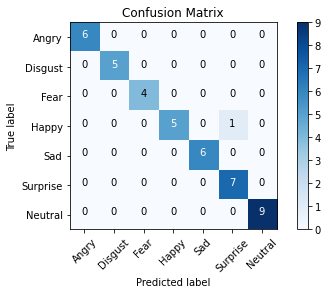

3/3 - 2s - loss: 0.2346 - acc: 0.9767
Accuracy：97.67%


In [5]:

if __name__ == '__main__':
    Data.load_train_data(filename="JAFFE")
    ## 畫出混淆矩陣
    #   1. 指定模型
    model = load_model('/content/drive/MyDrive/basic_emotion/callbacks.01-0.90909.hdf5')
    model.summary()
    #   2. 資料前處理
    x = np.load('/content/drive/MyDrive/basic_emotion/JAFFE_test_x.npy')
    y = np.load('/content/drive/MyDrive/basic_emotion/JAFFE_test_y.npy')
    x = Data.static_arr_reshape(arr=x)
    # #   3. 呼叫方法畫出混淆矩陣
    Evaluate.confusion_matrix(model=model,
                          cls='be',
                          x=x,
                          y=y)
    # #   4. 評估模型準確率
    Evaluate.evaluate(model=model, x=x, y=y)
    #   5. 預測模型準確率
    # x = Data.static_arr_reshape(arr=np.load('D:\\NianXiang_File\\Research\\Dataset\\gaga_predict_x.npy'))
    # print(x.shape)
    # predict = Evaluate.predict(model=model, x=x)
    # np.save('gaga_predict_data.npy', predict)